In [23]:
import torch
import torch.nn as nn
import os
import numpy as np
import random
from openslide import open_slide
from PIL import Image
from torch.utils.data import Dataset

In [2]:
Image.MAX_IMAGE_PIXELS = None

### Data functions

In [3]:
class Patch:
    '''
    Store properties of each patch
    '''

    def __init__(self, image, position, size=256):
        self.image = image
        self.position = position
        self.size = size
        self.probability = None
        self.prediction = None
        self.is_background = False
    
    def set_probability(self, probability):
        self.probability = probability

    def get_prediction(self):
        self.prediction = 1 if self.probability >= 0.5 else 0

### Helper functions

In [87]:
def load_trained_model(num_classes, model_path): 

    model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    # INCEPTION
    # # Define model architecture
    # model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
    # # Replace last layers with new layers
    # num_ftrs = model.fc.in_features
    # model.fc = nn.Sequential(
    #     nn.Linear(num_ftrs, 2048),
    #     nn.ReLU(inplace=True),
    #     nn.Dropout(p=0.7),
    #     nn.Linear(2048, num_classes),
    #     nn.Softmax(dim=1)
    # )

    # Load the saved model state dict
    model.load_state_dict(torch.load(model_path))

    # Set the model to evaluation mode
    model.eval()

    return model

def scale_tensor(tensor: torch.Tensor):
    '''
    Scale a tensor to the range [0, 1]
    '''
    minn = tensor.min()
    maxx = tensor.max()
    tensor = (tensor - minn)/(maxx - minn)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

def image_to_patches_with_positions(image, patch_size: int, stride: int):
    '''
    Function for splitting an input image into patches.

    Parameters:
    image: input image to split
    patch_size (int): dimension, patches will be square
    stride (int): controls overlap between patches

    Returns:
    Tensor of patches with shape (num_patches, im_dim (if applicable), patch_size, patch_size) with their positions in the original image
    '''
    # Convert image to PyTorch tensor
    im = torch.from_numpy(image)
    # Scale image to [0, 1]
    im = scale_tensor(im)

    # Is image colour or binary?
    image_dimension = 3 if len(image.shape) == 3 else 1
    # Working with a colour image
    if image_dimension == 3:
        # Extract patches
        patches = im.unfold(0, patch_size, stride).unfold(1, patch_size, stride)
        # Reshape tensor into tensor of shape (num_patches, 3, patch_size, patch_size)
        patches = patches.contiguous().view(-1, image_dimension, patch_size, patch_size) ###.contiguous() ensure tensor is stored in contiguous block of memory which is required for .view()
    # Working with greyscale image
    else:
        # Extract patches
        patches = im.unfold(0, patch_size, stride).unfold(1, patch_size, stride)
        # Reshape tensor into tensor of shape (num_patches, patch_size, patch_size)
        patches = patches.contiguous().view(-1, patch_size, patch_size)

    # Calculate the number of patches in each dimension
    height, width = image.shape[:2]
    num_patches_h = (height - patch_size) // stride + 1
    num_patches_w = (width - patch_size) // stride + 1

    # Generate positions of the patches
    positions = []
    for h in range(num_patches_h):
        for w in range(num_patches_w):
            # Calculate the top-left position of the current patch
            top = h * stride
            left = w * stride
            positions.append((top, left))

    return patches, positions

def get_patch_objects(patches, positions):
    patch_objects = []
    for patch, position in zip(patches, positions):
        patch_object = Patch(image=patch, position=position)
        patch_objects.append(patch_object)
    return patch_objects

## CHECK THIS FUNCTION PROPERLY for my data
def check_if_background(patch):
    '''
    Given a patch, return whether it should be classified as a background patch or not.
    '''
    # working with actual patch now and NOT the mask?????????????????
    im = np.array(patch) * 255
    pixels = np.ravel(im)
    mean = np.mean(pixels)
    is_background = mean >= 220
    return is_background

def choose_random_image(directory, seed):
    '''
    Choose a SVS file randomly to perform inference and produce heatmap.

    Return level 1 image from SVS file as well as the images case code.
    '''
    random.seed(seed)
    files = os.listdir(directory)
    svs_files = [file for file in files if file.endswith(('.svs'))]
    # Randomly choose file
    random_svs = random.choice(svs_files)
    print(random_svs)
    name = random_svs.replace('.svs', '')
    if name.startswith('._'):
        name = name.replace('._', '')
    case_code = name.split('.')[0].replace('TCGA-', '').replace('-01Z-00-DX1', '')
    slide_path = os.path.join(directory, random_svs)
    sld = open_slide(slide_path)
    slide_props = sld.properties
    slide_width = int(slide_props['openslide.level[1].width']); slide_height = int(slide_props['openslide.level[1].height']) # dimensions at 10X magnification
    slide = np.array(sld.get_thumbnail(size=(slide_width, slide_height)))

    return case_code, slide

# def check_seg_accuracy(label_directory, case_code):
#     # get image labels for 
#     # going to run into problem: what if there arent the same number of background patches as this algorithm returns - wont be able to calculate accuracy
#     return acc

def get_prediction(patch, output):
    # preprocess

    # get predictions for patch
    probabilities = torch.softmax(output, dim=1) # Post-process the predictions
    patch.probability = probabilities[0][1].item()
    predicted_class = torch.argmax(probabilities, dim=1).item()
    patch.prediction = predicted_class

def create_heatmap(image_size, patches):
    '''
    Generate the heatmap array based on patch predicted probabilities.
    '''
    heat_map = np.zeros(image_size)
    for patch in patches:
        i, j = patch.position
        h, w = patch.size
        heat_map[i:i+h, j+j+w] = patch.probability
    return heat_map

def inference(image_size, patches, model):
    '''
    Takes in Patch objects and makes predictions for each patch if it is not classified as a background patch.
    Then uses those predictions to create a heatmap
    '''
    for patch in patches:
        image = patch.image
        is_background = check_if_background(image)
        if not is_background:
            model.eval()
            with torch.no_grad():
                output = model(image.unsqueeze(0))
            get_prediction(patch, output)
        else:
            patch.probability = 0
            patch.prediction = 0
    heatmap = create_heatmap(image_size, patches)
    return heatmap

# def visualise_heatmap():

In [6]:
PATCH_SIZE=256
STRIDE=PATCH_SIZE
num_classes=2
SEED=42

In [ ]:
images_directory = '/Volumes/AlexS/MastersData/SVS files/'
labels_directory = '/Volumes/AlexS/MastersData/processed/labels/'

### Main

In [ ]:
# load image
image = choose_random_image(images_directory, SEED)
image_size = image.shape
# extract patches
patches, positions = image_to_patches_with_positions(image, PATCH_SIZE, STRIDE)
# create Patch objects
patch_objects = get_patch_objects(patches, positions)
# Get trained model
model_path = '../models/splendid-dawn-22_model_weights.pth'
model = load_trained_model(num_classes, model_path)
heatmap = inference(image_size, patch_objects, model)

### Notes

- Want to be able to overlay this produced heatmap over the original slide
- Also need to create heatmap of the original slide with its classes to visualise what is the ground truth segmentation using patches
- when using the inception model, remember to apply the preprocessing steps to the image before making predictions

### Testing functions

In [7]:
slide_path = '/Users/alexandrasmith/Desktop/TCGA-A2-A0CX-01Z-00-DX1.F07C75AB-E568-45CB-B497-37C712490393.svs'
name = 'TCGA-A2-A0CX-01Z-00-DX1.F07C75AB-E568-45CB-B497-37C712490393.svs'
case_code = name.split('.')[0].replace('TCGA-', '').replace('-01Z-00-DX1', '')
print(case_code)
sld = open_slide(slide_path)
slide_props = sld.properties
slide_width = int(slide_props['openslide.level[1].width']); slide_height = int(slide_props['openslide.level[1].height']) # dimensions at 10X magnification
slide = np.array(sld.get_thumbnail(size=(slide_width, slide_height)))

A2-A0CX


There should be 5530 total patches for this image

Issues to consider:
- I deleted a bunch of patches (black/grey spots, etc) which will cause issues since they won't be detected as white/background so the model will make bad predictions on them!!

In [8]:
patches, positions = image_to_patches_with_positions(slide, PATCH_SIZE, STRIDE)

In [13]:
print(patches.shape)
print(len(positions))

torch.Size([5530, 3, 256, 256])
5530


In [14]:
patch_objects = get_patch_objects(patches, positions)

In [30]:
print(len(patch_objects))
print(patch_objects[0].image.shape)

5530
torch.Size([3, 256, 256])


In [44]:
# Get trained model
model_path = '../models/splendid-dawn-22_model_weights.pth'
model = load_trained_model(num_classes, model_path)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model = model.to(device)

In [88]:
image_size = slide.shape
heatmap = inference(image_size, patch_objects, model)

TypeError: cannot unpack non-iterable int object

Text(0.5, 1.0, 'Predicted class: 1')

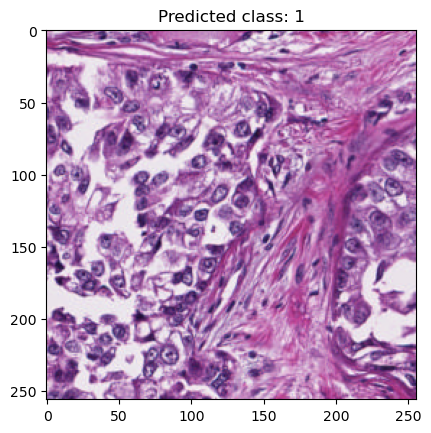

In [90]:
import matplotlib.pyplot as plt
# Test one patch and its prediction
ex_patch = patch_objects[4010]
p1 = ex_patch.image
pred = ex_patch.prediction

plt.imshow(np.transpose(p1.numpy(), (1, 2, 0)))
plt.title(f"Predicted class: {pred}")

In [47]:
from torchvision import transforms
from torch.utils.data import Dataset
import random
import torch.utils.data as data_utils

In [48]:
# Split image folders into train, val, test
def split_data(patch_directory, split: list, seed):
    '''
    Function that takes in the split percentage for train/val/test sets, and randomly chooses which cases
    to allocate to which set (to ensure all patches from one case go into one set)
    Parameters:
    patch_directory: folder containing all patches
    split: list of integers for splitting sets
    seed: option to set the seed value for randomness
    Returns:
    3 lists for each of train/val/test, where each list contains the case names to be used in the set
    '''
    
    random.seed(seed)

    case_folders = os.listdir(patch_directory) # get 147 case folders
    
    d = {}
    for folder in case_folders:
        num_patches_in_folder = len(os.listdir(patch_directory + folder))
        d[folder] = num_patches_in_folder
    
    total_num_patches = sum(d.values())
    train_split, val_split, test_split = split
    train_num_patches = int((train_split/100)*total_num_patches)
    val_num_patches = int((val_split/100)*total_num_patches)

    # list all folders in the directory
    folders = [os.path.join(patch_directory, folder) for folder in os.listdir(patch_directory) if os.path.isdir(os.path.join(patch_directory, folder))]
    
    # SELECT TRAINING CASES
    train_cases = [] # store all selected cases
    num_selected_train = 0 # number of patches selected so far
    selected_folders = set() # a set to store the selected folder names to keep track of those already selected
    while num_selected_train < train_num_patches:
        folder = random.choice(folders)
        if folder not in selected_folders:
            case = folder.replace(patch_directory, '')
            num_patches = len(os.listdir(folder))
            num_selected_train += num_patches
            selected_folders.add(folder) # add to set of selected folders
            train_cases.append(case)

    # SELECT VAL CASES
    val_cases = [] # store all selected cases
    num_selected_val = 0 # number of patches selected so far
    while num_selected_val < val_num_patches:
        folder = random.choice(folders)
        if folder not in selected_folders:
            case = folder.replace(patch_directory, '')
            num_patches = len(os.listdir(folder))
            num_selected_val += num_patches
            selected_folders.add(folder)
            val_cases.append(case)

    # SELECT TEST CASES
    cases = [folder.replace(patch_directory, '') for folder in folders]
    used = train_cases+val_cases
    test_cases = [case for case in cases if case not in used]
    
    # test_patches = [len(os.listdir(patch_directory + folder)) for folder in test_cases]
    num_selected_test = sum([len(os.listdir(patch_directory + folder)) for folder in test_cases])
    # dict = {x: for x in ['train', 'val', 'test']}
    print(f"Number of training patches: {num_selected_train} \nNumber of validation patches {num_selected_val} \nNumber of test patches {num_selected_test}")
    return train_cases, val_cases, test_cases

# Create a custom PyTorch dataset to read in your images and apply transforms

class CustomDataset(Dataset):
    def __init__(self, img_folders, label_files, transform=None):
        self.img_folders = img_folders
        self.label_files = label_files
        self.transform = transform

        self.imgs = [] # Keeps image paths to load in the __getitem__ method
        self.labels = []

        # Load images and corresponding labels
        for i, (img_folder, label_file) in enumerate(zip(img_folders, label_files)):
            # print("Patch directory", img_folder, "\nLabel file", label_file)
            labels_pt = torch.load(label_file) # Load .pt file
            # Run through all patches from the case folder
            for i, img in enumerate(os.listdir(img_folder)):
                if os.path.isfile(img_folder + '/' + img) and os.path.isfile(label_file):
                    # print(img_folder + img)
                    if img.startswith('._'):
                        img = img.replace('._', '')
                    idx = int(img.replace('.png', '').split("_")[1])
                    self.imgs.append(img_folder + '/' + img)
                    self.labels.append(labels_pt[idx].item()) # get label as int
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        # Load image at given index
        image_path = self.imgs[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform is not None: # Apply transformations
            image = self.transform(image)
        
        label = self.labels[idx] # Load corresponding image label
        
        return image, label # Return transformed image and label

In [54]:
# DATALOADERS
batch_size = 64
num_cpus=8
# Initialise data transforms
data_transforms = {
    'train': transforms.Compose([
        # transforms.Resize(INPUT_SIZE),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
        # transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# using full set of data
img_dir = '/Volumes/AlexS/MastersData/processed/patches/'
labels_dir = '/Volumes/AlexS/MastersData/processed/labels/'

split=[70, 15, 15] # for splitting into train/val/test

train_cases, val_cases, test_cases = split_data(img_dir, split, SEED)

train_img_folders = [img_dir + case for case in train_cases]
val_img_folders = [img_dir + case for case in val_cases]
test_img_folders = [img_dir + case for case in test_cases]

# Contains the file path for each .pt file for the cases used in each of the sets
train_labels = [labels_dir + case + '.pt' for case in train_cases]
val_labels = [labels_dir + case + '.pt' for case in val_cases]
test_labels = [labels_dir + case + '.pt' for case in test_cases]

image_datasets = {
    'train': CustomDataset(train_img_folders, train_labels, transform=data_transforms['train']),
    'val': CustomDataset(val_img_folders, val_labels, transform=data_transforms['val']),
    'test': CustomDataset(test_img_folders, test_labels, transform=data_transforms['test'])
}
# Create training, validation and test dataloaders
dataloaders = {
    'train': data_utils.DataLoader(image_datasets['train'], batch_size=batch_size, num_workers=num_cpus, shuffle=True, drop_last=True),
    'val': data_utils.DataLoader(image_datasets['val'], batch_size=batch_size, num_workers=num_cpus, shuffle=True),
    'test': data_utils.DataLoader(image_datasets['test'], batch_size=batch_size, num_workers=num_cpus, shuffle=True)
}


Number of training patches: 256702 
Number of validation patches 55642 
Number of test patches 52242


In [55]:
def test_model(test_loader):
    
    correct = 0
    total = 0
    
    # Create a progress bar
    progress_bar = tqdm(test_loader, desc='Testing', unit='batch')

    with torch.no_grad():
        for inputs, labels in progress_bar:
            # move to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            print(inputs.shape)
            print(len(labels))

            # Forward pass
            outputs = model(inputs)
            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # _, preds = torch.max(outputs, 1)

            # Update variables
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar description
            progress_bar.set_postfix({'Accuracy': '{:.2f}%'.format((correct / total) * 100)})
    
    # Compute accuracy
    accuracy = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))
    # Close the progress bar
    progress_bar.close()
    
    return accuracy

In [57]:
from tqdm import tqdm

In [58]:
accuracy = test_model(dataloaders['test'])

Testing:   0%|          | 0/817 [00:00<?, ?batch/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/alexandrasmith/miniforge3/envs/masters/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/alexandrasmith/miniforge3/envs/masters/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'CustomDataset' on <module '__main__' (built-in)>
Testing:   0%|          | 0/817 [01:00<?, ?batch/s]


KeyboardInterrupt: 